# Data Profiling and Imputation

This notebook demonstrates an exercise at profiling the data for null values and replacing these with non-null values using concepts such as conditional probability.

**Reading the Input File**

In [12]:
import pandas as pd
import numpy as np
df=pd.read_csv('../flixNet/dataset/data/attributes.csv')

**Checking the Sample size for each Attribute**


In [13]:
sample_neck=df.neck.dropna().unique().tolist()
sample_neck_length=len(sample_neck)
print("There are {} variations in neck size. All the values include:-{}".format(sample_neck_length,sample_neck))
sample_sleeve=df.sleeve_length.dropna().unique().tolist()
sample_sleeve_length=len(sample_sleeve)
print("There are {} variations in sleeve length. All the values include:-{}".format(sample_sleeve_length,sample_sleeve))
sample_pattern=df.pattern.dropna().unique().tolist()
sample_pattern_length=len(sample_pattern)
print("There are {} variations in patterns. All the values include:-{}".format(sample_pattern_length,sample_pattern))



There are 7 variations in neck size. All the values include:-[6.0, 5.0, 1.0, 4.0, 0.0, 2.0, 3.0]
There are 4 variations in sleeve length. All the values include:-[3.0, 1.0, 0.0, 2.0]
There are 10 variations in patterns. All the values include:-[4.0, 9.0, 8.0, 6.0, 1.0, 3.0, 7.0, 2.0, 0.0, 5.0]


Here we check the frequency of null values among various attributes. 

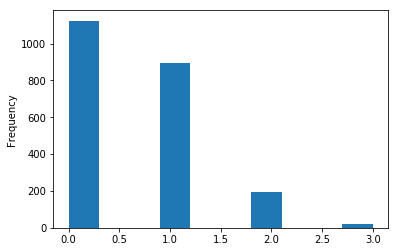

In [14]:
from matplotlib import pyplot

for i in df.index:
    row=pd.Series(df.loc[i,['neck','sleeve_length','pattern']])
    df.loc[i,'no_of_missing']=row.isnull().sum()
    #Concatenate all the attribute values in a row.
    df.loc[i,'all_fields_str']=str(df.loc[i,'neck'])+'-'+str(df.loc[i,'sleeve_length'])+'-'+str(df.loc[i,'pattern'])

df.no_of_missing.plot('hist')

As shown in the graph it is clearly evident that around 1300 rows have all the values present. However,    

1) No of rows missing one value is around 900  
2) No of rows missing two values is around 220  
3) Very few values have all the values missing  

We shall tackle them one by one.

# All Three Attributes are NULL

Here we try to find out the combination of the three attributes that is the most frequent in the dataset.

In [15]:
most_common=pd.DataFrame.from_dict(df['all_fields_str'].value_counts().to_dict(),orient='index',columns=['frequency_of_tshirt'],dtype='int')
most_common['pattern_type']=most_common.index
most_common.reset_index(inplace=True,drop=True)
most_common_combination = most_common[most_common.frequency_of_tshirt==most_common['frequency_of_tshirt'].max()]
print(most_common_combination.pattern_type[0])

6.0-3.0-9.0


As we can see that the most common combination of neck, sleeve length and pattern attributes is **6,3,9** repectively.
We will replace all instances where all the three attributes are null with these values.

In [16]:
for i in df[df.no_of_missing==3.0].index:
        df.loc[i,'neck']=6.0
        df.loc[i,'sleeve_length']=3.0
        df.loc[i,'pattern']=9.0
        df.loc[i,'no_of_missing']=0.0

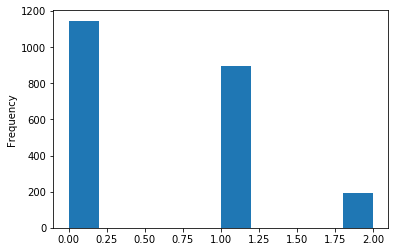

In [17]:
for i in df.index:
    row=pd.Series(df.loc[i,['neck','sleeve_length','pattern']])
    df.loc[i,'no_of_missing']=row.isnull().sum()
df.no_of_missing.plot('hist')

From the graph above, it is evident that the above operation removed all the cases of triple null values.

# Two Attributes are NULL

Dealing with cases where two out of three attributes are null, we can make use of conditional probability to predict the probability of the missing values and fill values accordingly. 

For each non-null value of an attribute, we calculate the probability of occurence of all combinations of the other two attributes.For instance, if a row is 4,#NA,#NA. Here, given that neck =4, we'll try to find out the probability of all combinations of other two attributes such as (0,1), (2,4), (3,4) etc.

In [18]:
import itertools

def probab_when_two_nulls(df,attribute,value):
    if(attribute=='neck'):
        product=list(itertools.product(sample_sleeve,sample_pattern))
        probablist=[]
        for i in product:
            probability=len(df[(df.neck==value) & (df.sleeve_length==i[0]) & (df.pattern==i[1])])/len(df[df.neck==value])
            probablist.append([value,i[0],i[1],probability])
        tempdf=pd.DataFrame(probablist,columns=['neck','sleeve_length','pattern','probability'])
        return(tempdf[tempdf['probability'].max()==tempdf.probability])
    
    elif(attribute=='sleeve_length'):
        product=list(itertools.product(sample_neck,sample_pattern))
        probablist=[]
        for i in product:
            probability=len(df[(df.neck==i[0]) & (df.sleeve_length==value) & (df.pattern==i[1])])/len(df[df.sleeve_length==value])
            probablist.append([i[0],value,i[1],probability])
        tempdf=pd.DataFrame(probablist,columns=['neck','sleeve_length','pattern','probability'])
        return(tempdf[tempdf['probability'].max()==tempdf.probability])
    else:
        product=list(itertools.product(sample_neck,sample_sleeve))
        probablist=[]
        for i in product:
            probability=len(df[(df.neck==i[0]) & (df.sleeve_length==i[1]) & (df.pattern==value)])/len(df[df.pattern==value])
            probablist.append([i[0],i[1],value,probability])
        tempdf=pd.DataFrame(probablist,columns=['neck','sleeve_length','pattern','probability'])
        return(tempdf[tempdf['probability'].max()==tempdf.probability])

   
neck_fillers = pd.DataFrame(dtype=float)
sleeve_fillers = pd.DataFrame(dtype=float)
pattern_fillers = pd.DataFrame(dtype=float)

for i in sample_neck:
    temp = probab_when_two_nulls(df,'neck',i)
    neck_fillers = neck_fillers.append(temp)
for i in sample_sleeve:
    temp = probab_when_two_nulls(df,'sleeve_length',i)
    sleeve_fillers = sleeve_fillers.append(temp)
for i in sample_pattern:
    temp = probab_when_two_nulls(df,'pattern',i)
    pattern_fillers = pattern_fillers.append(temp)
    
for i in df[df.no_of_missing==2.0].index:
    if(str(df.loc[i,'neck']).lower()!='nan'):
        a=df.loc[i,'neck']
        df.loc[i,'pattern']=neck_fillers[neck_fillers.neck==df.loc[i,'neck']]['pattern'].tolist()[0]
        df.loc[i,'sleeve_length']=neck_fillers[neck_fillers.neck==df.loc[i,'neck']]['sleeve_length'].tolist()[0]
        df.loc[i,'no_of_missing']=0.0        
    if(str(df.loc[i,'sleeve_length']).lower()!='nan'):
        df.loc[i,'neck']=sleeve_fillers[sleeve_fillers.sleeve_length==df.loc[i,'sleeve_length']]['neck'].tolist()[0]
        df.loc[i,'pattern']=sleeve_fillers[sleeve_fillers.sleeve_length==df.loc[i,'sleeve_length']]['pattern'].tolist()[0]
    if(str(df.loc[i,'pattern']).lower()!='nan'):
        df.loc[i,'neck']=pattern_fillers[pattern_fillers.pattern==df.loc[i,'pattern']]['neck'].tolist()[0]
        df.loc[i,'sleeve_length']=pattern_fillers[pattern_fillers.pattern==df.loc[i,'pattern']]['sleeve_length'].tolist()[0]

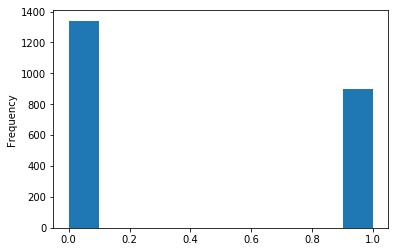

In [19]:
for i in df.index:
    row=pd.Series(df.loc[i,['neck','sleeve_length','pattern']])
    df.loc[i,'no_of_missing']=row.isnull().sum()
df.no_of_missing.plot('hist')

We now have only cases where one attribute value in a row is null.

# One Attribute is NULL

Finally, we handle the case where only one attribute value is null. Here too we find the attribute value using conditional probability with a subtle difference. Here, we are going to find the probability of one attribute given that the other two are already known. 

In [20]:
def fill_one_missing_value(df,attribute,value1,value2):
    
    if (attribute=='neck'):
        sleeve=value1
        pattern=value2
        prob_list=[]
        for i in sample_neck:
            probability=len(df[(df.sleeve_length==sleeve)&(df.neck==i)&(df.pattern==value2)])/len(df[(df.sleeve_length==sleeve)&(df.pattern==pattern)])
            prob_list.append([i,sleeve,pattern,probability])
        tempdf=pd.DataFrame(prob_list,columns=['neck','sleeve_length','pattern','probability'])
        
        return(tempdf[tempdf['probability'].max()==tempdf.probability])
    
    if (attribute=='sleeve_length'):
        neck=value1
        pattern=value2
        prob_list=[]
        for i in sample_sleeve:
            probability=len(df[(df.sleeve_length==i)&(df.neck==value1)&(df.pattern==value2)])/len(df[(df.neck==neck)&(df.pattern==pattern)])
            prob_list.append([neck,i,pattern,probability])
        tempdf=pd.DataFrame(prob_list,columns=['neck','sleeve_length','pattern','probability'])
        
        return(tempdf[tempdf['probability'].max()==tempdf.probability])
    
    if (attribute=='pattern'):
        neck=value1
        sleeve=value2
        prob_list=[]
        for i in sample_pattern:
            probability=len(df[(df.sleeve_length==value2)&(df.neck==value1)&(df.pattern==i)])/len(df[(df.sleeve_length==sleeve)&(df.neck==neck)])
            prob_list.append([neck,sleeve,i,probability])
        tempdf=pd.DataFrame(prob_list,columns=['neck','sleeve_length','pattern','probability'])
        
        return(tempdf[tempdf['probability'].max()==tempdf.probability])
    
for i in df[df.no_of_missing==1].index:
    if(str(df.loc[i,'neck']).lower()=='nan'):
        temp=fill_one_missing_value(df,'neck',df.loc[i,'sleeve_length'],df.loc[i,'pattern'])
        temp.reset_index(inplace=True,drop=True)
        df.loc[i,'neck']=temp.loc[0,'neck']
    if(str(df.loc[i,'sleeve_length']).lower()=='nan'):
        temp=fill_one_missing_value(df,'sleeve_length',df.loc[i,'neck'],df.loc[i,'pattern'])
        temp.reset_index(inplace=True,drop=True)
        df.loc[i,'sleeve_length']=temp.loc[0,'sleeve_length']
    if(str(df.loc[i,'pattern']).lower()=='nan'):
        temp=fill_one_missing_value(df,'pattern',df.loc[i,'neck'],df.loc[i,'sleeve_length'])
        temp.reset_index(inplace=True,drop=True)
        df.loc[i,'pattern']=temp.loc[0,'pattern']
            

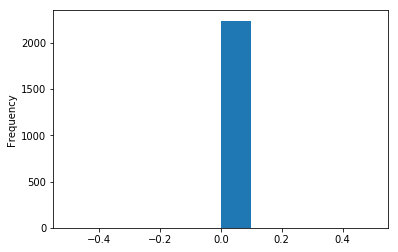

In [21]:
for i in df.index:
    row=pd.Series(df.loc[i,['neck','sleeve_length','pattern']])
    df.loc[i,'no_of_missing']=row.isnull().sum()
df.no_of_missing.plot('hist')

Finally, all the null values have been removed from the dataset. We now save the annotation file for model training.

In [23]:
final_df = df[['filename', 'neck', 'sleeve_length', 'pattern']].copy()
final_df.to_csv('dataset/data/data_imutated.csv', index=False)